# Lange Symposium 2020 - GWAS for Ordinal Phenotypes with *OrdinalGWAS.jl* #

This tutorial demonstrates how to conduct GWAS on ordinal phenotypes using [OrdinalGWAS.jl](https://www.github.com/OpenMendel/OrdinalGWAS.jl). We will demonstrate various procedures that this software package can perform.

OrdinalGWAS.jl is a Julia package for performing genome-wide association studies (GWAS) for ordered categorical phenotypes using [proportional odds model](https://en.wikipedia.org/wiki/Ordered_logit) or [ordred Probit model](https://en.wikipedia.org/wiki/Ordered_probit). It is useful when the phenotype takes ordered discrete values, e.g., disease status (undiagnosed, pre-disease, mild, moderate, severe). This is especially common in complex diseases where a binary status may not be suitable for all individuals. 

## Outline
* Motivation
* Model
* Basic Usage
    * Input files
    * Running a simple analysis
    * Output files
* Customized Analysis
    * Restricting sample/snps
    * Link functions
    * LRT & score tests
    * SNP-set analysis (with annotation file)
* Additional Features in Documentation
* Example (if time)

## Motivation

The following is a phenotyping algorithm from [Eastwood et al. (2016)](https://dx.doi.org/10.1371%2Fjournal.pone.0162388) for diagnosing type II diabetes in the UK biobank population. 

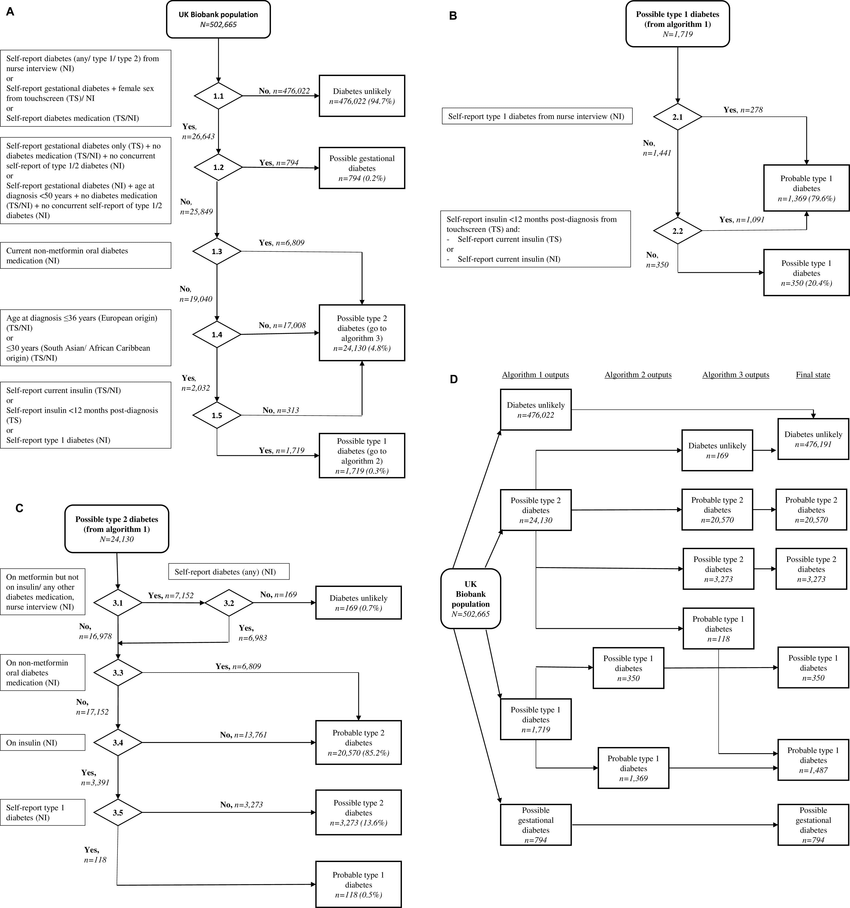

Labels generated include likelihood of diabetes, relying on several variables.

Hard to dichotomize. 

Other types of ordinal phenotypes:

* Disease Severity

* Disease Progression

* Maximum stage of a disease reached under treatment


## Model

*OrdinalGWAS.jl* uses an ordered multinomial model, by default it runs the null model and then performs a score test for each SNP using the null model. 

* Assume trait $Y$ takes ordinal values $j \in \{1, \ldots, J\}$.
* Cumulative probabilities $\alpha_{ij} = \mathbb{P}(Y_i \le j)$ are linked to covariates $\mathbf{x}_i$ via
$$
	g(\alpha_{ij}) = \theta_j - \mathbf{x}_i^T \boldsymbol{\beta}, \quad j = 1,\ldots, J-1,
$$
where $g$ is a strictly increasing link function.
* Intercepts $\theta_1 \le \cdots \le \theta_{J-1}$ enforces order between categories and regression coefficients $\boldsymbol{\beta}$ reflects effects of covariates.


For reproducibility, check the machine information below. To execute a notebook command, hold down Shift and Enter within the box. This tutorial and corresponding modules have been checked with Julia versions 1.0 and 1.3.

In [ ]:
# machine information for this tutorial
versioninfo()

In [ ]:
# for use in this tutorial
using CSV, OrdinalGWAS, SnpArrays

## Basic usage

## Example data set

The `data` folder contains an example data set with a simulated covariate in covariate.txt.

In [ ]:
# content of the data folder
readdir("data")

### Input files

`ordinalgwas` expects two input files: one for responses plus covariates (second argument), the other the Plink files for genotypes (third argument).

#### Covariate and trait file

Covariates and phenotype are provided in a csv file, e.g., `covariate.txt`, which has one header line for variable names. In this example, variable `hypertension` representing levels of hypertension is the ordered categorical phenotypes coded as integers 1 to 4. We want to include variable `sex` as the covariate in GWAS.

In [ ]:
run(`head data/covariate.txt`);

### Genotype data in PLINK format

We can use *SnpArrays.jl* to read in the raw genotype data.

In [ ]:
s1 = SnpArray("data/hapmap3.bed")

In this example, there are 324 individuals genotyped at 13,928 SNPs.

## Analysis

The following command performs GWAS using the [proportional odds model](https://en.wikipedia.org/wiki/Ordered_logit) as the default when no link function is specified. The output is the fitted null model.

### Formula for null model

The first argument specifies the null model without SNP effects, e.g., `@formula(hypertension ~ sex)`.

In [ ]:
ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3")

For documentation of the `ordinalgwas` function, type `?ordinalgwas` in Julia REPL.

In [ ]:
?ordinalgwas

Compressed Plink files are supported. For example, if Plink files are `hapmap3.bed.gz`, `hapmap3.bim.gz` and `hapmap3.fam.gz`, the same command
```julia
ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3")
```
still works. Check all supported compression format by

In [ ]:
SnpArrays.ALLOWED_FORMAT

### Output files

`ordinalgwas` outputs two files: `ordinalgwas.null.txt` and `ordinalgwas.pval.txt`. 

* `ordinalgwas.null.txt` lists the estimated null model (without SNPs). 

In [ ]:
run(`cat ordinalgwas.null.txt`);

* `ordinalgwas.pval.txt` tallies the SNPs and their pvalues. 

In [ ]:
ENV["COLUMNS"]=120 #shows up to 10 columns for dataframe displays
CSV.read("ordinalgwas.pval.txt")

In [ ]:
#clean up files 
rm("ordinalgwas.null.txt", force=true)
rm("ordinalgwas.pval.txt", force=true)

Output file names can be changed by the `nullfile` and `pvalfile` keywords respectively. For example, 
```julia
ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3", pvalfile="ordinalgwas.pval.txt.gz")
```
will output the p-value file in compressed gz format.

### Timing

For this moderate-sized data set (N = 324 SNPs = 13,928), `ordinalgwas` takes around 0.3 seconds.

In [ ]:
@time(ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3"));

In [ ]:
#clean up files 
rm("ordinalgwas.null.txt", force=true)
rm("ordinalgwas.pval.txt", force=true)

We have applied this software to the COPDGene cohort (N = 5,953, Nsnps = 630,860) and the UKBiobank cohort (N = 185,565, Nsnps =  464,137) published in [Genetic Epidemiology](https://doi.org/10.1002/gepi.22276). Runtimes were 3.5  minutes and 181 minutes respectively. 

## SNP and/or sample masks

In practice, we often perform GWAS on selected SNPs and/or selected samples. They can be specified by the `snpinds`, `covrowinds` and `bedrowinds` keywords of `ordinalgwas` function. 

For example, to perform GWAS on SNPs with minor allele frequency (MAF) above 0.05

In [ ]:
# create SNP mask
snpinds = maf(SnpArray("data/hapmap3.bed")) .≥ 0.05
# GWAS on selected SNPs
@time ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3", 
    snpinds=snpinds, nullfile="commonvariant.null.txt", pvalfile="commonvariant.pval.txt")

In [ ]:
CSV.read("commonvariant.pval.txt")

In [ ]:
# extra header line in commonvariant.pval.txt
countlines("commonvariant.pval.txt"), count(snpinds)

In [ ]:
# clean up
rm("commonvariant.null.txt", force=true)
rm("commonvariant.pval.txt", force=true)

`covrowinds` specify the samples in the covariate file and `bedrowinds` for SnpArray. User should be particularly careful when using these two keyword. Selected rows in SnpArray should exactly match the samples in the null model. Otherwise the results are meaningless.


Use the keyword `covrowinds` to specify selected samples in the covarite file. Use the keyword `bedrowinds` to specify selected samples in the Plink bed file. For example, to use the first 300 samples in both covariate and bed file:

In [ ]:
ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3", 
    nullfile="first300.null.txt", pvalfile="first300.pval.txt", covrowinds=1:300,
    bedrowinds=1:300)

In [ ]:
CSV.read("first300.pval.txt")

In [ ]:
# clean up
rm("first300.null.txt", force=true)
rm("first300.pval.txt", force=true)

## Likelihood ratio test (LRT)

By default, `ordinalgwas` calculates p-value for each SNP using score test. Score test is fast because it doesn't require fitting alternative model for each SNP. User can request likelihood ratio test (LRT) using keyword `test=:lrt`. LRT is much slower but may be more powerful than score test.

In [ ]:
@time ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3"; snpinds = 1:10, 
    test=:LRT, nullfile="lrt.null.txt", pvalfile="lrt.pval.txt")

Note the extra `effect` column in pvalfile, which is the effect size (regression coefficient) for each SNP. 

In [ ]:
CSV.read("lrt.pval.txt")

In [ ]:
# clean up
rm("lrt.pval.txt", force=true)
rm("lrt.null.txt", force=true)

In this example, GWAS by score test takes less than 0.2 second, while GWAS by LRT takes about 20 seconds. About 100 fold difference in run time. 

## Score test for screening, LRT for power 

For large data sets, a practical solution is to perform score test first, then re-do LRT for the most promising SNPs according to score test p-values.

**Step 1**: Perform score test GWAS, results in `score.pval.txt`.

In [ ]:
@time ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3", 
    test=:score, pvalfile="score.pval.txt");

In [ ]:
CSV.read("score.pval.txt")

**Step 2**: Sort score test p-values and find top 10 SNPs.

In [ ]:
scorepvals = CSV.read("score.pval.txt")[!, 6] # p-values in 5th column
tophits = sortperm(scorepvals)[1:10] # indices of 10 SNPs with smallest p-values
scorepvals[tophits] # smallest 10 p-values

**Step 3**: Re-do LRT on top hits.

In [ ]:
@time ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3", 
    snpinds=tophits, test=:LRT, pvalfile="lrt.pval.txt");

In [ ]:
CSV.read("lrt.pval.txt")

In [ ]:
# clean up
rm("ordinalgwas.null.txt", force=true)
rm("score.pval.txt", force=true)
rm("lrt.pval.txt", force=true)

## SNP-set testing

In many applications, we want to test a SNP-set (testing if SNPs have a joint effect together). The function `ordinalsnpsetgwas()` can be used to do this. The following is an example of using an annotated file where each SNP has a gene annotation.

In [ ]:
run(`head data/hapmap_snpsetfile.txt`);

Now we just need to specify that file to run a snpset analysis.

In [ ]:
ordinalsnpsetgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3",
    pvalfile = "snpset.pval.txt", snpset = "data/hapmap_snpsetfile.txt")

In [ ]:
CSV.read("snpset.pval.txt")

In [ ]:
# clean up
rm("snpset.pval.txt", force=true)
rm("ordinalgwas.null.txt", force=true)

## Additional Features Available Not Covered Today

The following features are also available in *OrdinalGWAS.jl*. They are covered in the documentation found [here](https://openmendel.github.io/OrdinalGWAS.jl/latest/).


* Additional SNP-set analysis options
    * Sliding window
    * Specific set of snps
* GxE interaction analysis
* Link Functions
    * `LogitLink()`, proportional odds model (default),  
    * `ProbitLink()`, ordred Probit model,  
    * `CloglogLink()`, proportional hazards model, or 
    * `CauchyLink()`
* Set of multiple plink files (i.e. by chromosome)
    * Running on a cluster
* Running analysis with a Docker file
* Plotting
    * To plot the GWAS results, use the [MendelPlots.jl package](https://openmendel.github.io/MendelPlots.jl/latest/).

## GxE example (if time allows)

## GxE interactions

In many applications, the user may want to test the GxE interaction effect. This requires fitting the SNP in the null model and is quite slower, but the command `ordinalgwasGxE()` can be used test the interaction effect.
To do this you must specify the environmental variable in the command, either as a symbol, such as ":age" or as a string "age". 

For documentation of the `ordinalgwasGxE` function, type `?ordinalgwasGxE` in Julia REPL.
```@docs
?ordinalgwasGxE
```

In [ ]:
?ordinalgwasGxE

The following can be used to test if there is an interaction between `sex` and the first five SNPs in the data. 

In [ ]:
ordinalgwasGxE(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3",
    :sex, pvalfile = "gxe_snp.pval.txt", snpinds=1:5, test=:score)

In [ ]:
CSV.read("gxe_snp.pval.txt")

In [ ]:
# clean up
rm("gxe_snp.pval.txt", force=true)

Now try to run a GxE interaction analysis for the first five snps using an LRT (returns the effect size estimate of the GxE interaction as well), saving the results to a file named `gxe_lrt.pval.txt`.

In [ ]:
## Your code here:

###

Display the results 

In [ ]:
CSV.read("gxe_snp.pval.txt")

In [ ]:
# clean up
rm("gxe_snp.pval.txt", force=true)

## GxE interactions - testing joint effect

In some applications, the user may want to test SNP effect and/or its interaction with other terms. `testformula` keyword specifies the test unit **besides** the covariates in `nullformula`. 

In following example, keyword `testformula=@formula(hypertension ~ snp + snp & sex)` instructs `ordinalgwas` to test joint effect of `snp` and `snp & sex` interaction.

In [ ]:
ordinalgwas(@formula(hypertension ~ sex), "data/covariate.txt", "data/hapmap3", 
    pvalfile="GxE.pval.txt", testformula=@formula(hypertension ~ snp + snp & sex));

In [ ]:
CSV.read("GxE.pval.txt")

In [ ]:
# clean up
rm("ordinalgwas.null.txt")
rm("GxE.pval.txt")